# Antarctica: Neighbor Graphs

The goal of this notebook is to experiment using "neighbor graphs" to clean up the probe locations.

## Approach

Each probe can only be in 1 of 2 locations. Our goal then is to choose the most likely location for each probe. The challenge is to find a way to measure "likelihood" in this scenario.

The probes fit together like puzzle pieces. One location is more plausible than another if it fits in better with the locations around it. The more locations that fit together in a region, the more likely it is those locations are correct.

How to measure how well locations "fit" together? One way is to consider how closely a neighboring location matches the expected distance. For example, let's say we start from p0 in the following illustration. While p1 is clearly the nearest neighbor, p2 is a better fit because it's closer to the expected distance.

<center><img src="img/probe-fit.png" width="300"></center>

Given a starting location, we can quantify the fit of every other location as the difference between the distance and the expected distance. If we assume the best fitting location is correct, we can then repeat the search for the second location's best fitting nearest neighbor. We can follow this process to create a series of directed "neighbor graphs" with locations as nodes connected to the best fitting nearest neighbor.

Larger neighbor graphs provide stronger evidence that the locations are correct. This gives us a mechanism to incrementally step toward a "solution" by generating graphs for every location, declaring the largest one to be correct, and then repeating the process with the remaining locations.

# Setup

In [1]:
import random
from typing import Mapping, NamedTuple, Sequence

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import patches as patches
from matplotlib import pyplot as plt
from pandas import DataFrame
from tqdm import tqdm

import antarctica as aa

In [2]:
sns.set_style("whitegrid")

# Probes

First, we read and prepare the original data.

In [3]:
probes = aa.create_probes("data/probes.csv")
probes.head()

,x,y,distance_expected,distance_expected_err
probe_id,,,,
0,0.472751,1.302734,0.428625,0.021431
1,5.944659,11.519452,2.392850,0.119642
2,12.623399,15.411657,1.264116,0.063206
3,8.340580,3.964348,2.261914,0.113096
4,9.833046,14.837630,2.668234,0.133412


# Baseline

Before we start changing things, let's get a sense of how many errors there are with the initial data. We calculate a score for the probes data frame by walking through each probe, finding the nearest neighbor, measuring the delta between the expected distance and the actual distance, and adding them up. A perfect score of 0 would indicate all of the probes are exactly the expected distance from each other. The higher the score, the worse the "solution" is. We'll use this again at the end to compare multiple solutions side-by-side.

In [4]:
aa.score_probes(probes)

431.73716547216776

We can see we're starting with a baseline score of 432. Is this a high number? We won't know until we have something to compare it to.

# Catalog Locations

Next, we catalog all possible locations by duplicating each row and swapping x, y coordinates.

In [5]:
locations = aa.catalog_locations(probes)
locations.head()

,probe_id,x,y,distance_expected,distance_expected_err
location_id,,,,,
0,0,0.472751,1.302734,0.428625,0.021431
1,1,5.944659,11.519452,2.392850,0.119642
2,2,12.623399,15.411657,1.264116,0.063206
3,3,8.340580,3.964348,2.261914,0.113096
4,4,9.833046,14.837630,2.668234,0.133412


In [6]:
# Sample rows by probe
locations[locations.probe_id == 0]

,probe_id,x,y,distance_expected,distance_expected_err
location_id,,,,,
0,0,0.472751,1.302734,0.428625,0.021431
50,0,1.302734,0.472751,0.428625,0.021431


We can see above that probe 0 has 2 locations 0 and 50 with opposite x, y coordinates.

Below we can see all possible locations and expected distances to the nearest probe. The diagonal line differentiates alternate locations for each probe. All of the probes are represented on either side of the line. In an ideal solution, the probes' locations would fall exactly on the expected distance lines.

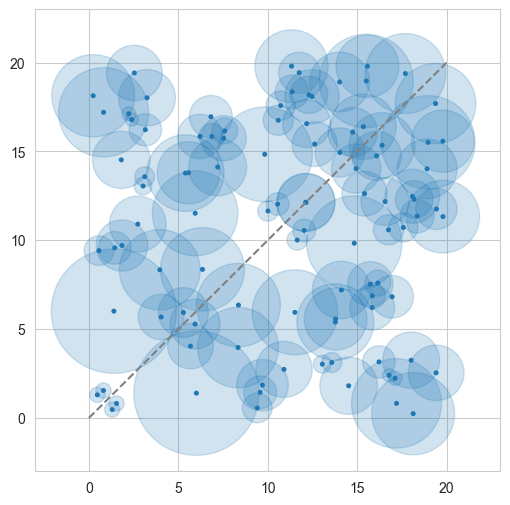

In [7]:
aa.plot.locations(locations)

# Neighbor Graphs

Now that we have all possible locations, we can create a series of directed "neighbor graphs". Given a starting location, we find the nearest location that is closest to the expected distance away. We then repeat the process starting from the new location. Each time we choose a best fitting nearest neighbor, we discard any locations that were nearer to the starting location from future consideration.

Let's walk through the process using location 71 in the bottom right as an example.

In [8]:
graph, candidates = aa.neighbor_graph(locations, location_id=71)
graph

{71: 20.0, 20.0: 96.0, 96.0: 20.0}

The neighbor graph starts at 71, goes to 20, then 96, and then back to 20. Let's try to highlight this process visually.

Text(0.5, 1.0, 'After')

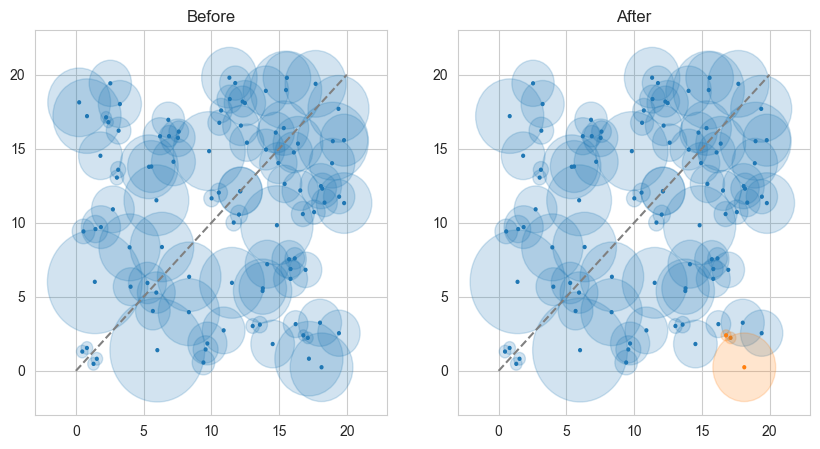

In [9]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(locations, ax=axs[0])
axs[0].set_title("Before")

aa.plot.locations(candidates, highlight=[71, 20, 96], ax=axs[1])
axs[1].set_title("After")

You can see that the neighbor graph for location 71 started in the bottom right and expanded to include the 2 locations above and to the left of it. If you look closely, you'll also see the remaining candidates no longer contain the location that was well inside location 71's expected distance.

# Iterating from Largest to Smallest

Neighbor graphs give us a mechanism to incrementally step toward a "solution" by generating graphs for every location, declaring the largest one to be correct, and then repeating the process with the remaining locations.

Let's walk through the process step-by-step to develop an intuition for how it works.

<Axes: ylabel='Count'>

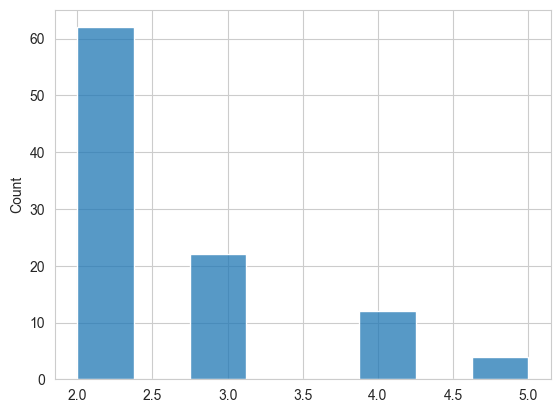

In [10]:
# Create neighbor graph for every location
graphs = {}
for location_id in locations.index:
    graph, _ = aa.neighbor_graph(locations, location_id=location_id)
    graphs[location_id] = graph

graph_lengths = {location_id: len(graphs[location_id]) for location_id in graphs}

sns.histplot(x=graph_lengths.values())

We can see above most of the graphs have size of 2, the some 3s and 4s, and only a small number of 5s. Let's take a closer look at the 5s.

In [11]:
[graphs[k] for k, v in graph_lengths.items() if v == 5]

[{44: 88.0, 88.0: 32.0, 32.0: 56.0, 56.0: 34.0, 34.0: 56.0},
 {45: 68.0, 68.0: 16.0, 16.0: 79.0, 79.0: 75.0, 75.0: 79.0},
 {94: 38.0, 38.0: 82.0, 82.0: 6.0, 6.0: 84.0, 84.0: 6.0},
 {95: 18.0, 18.0: 66.0, 66.0: 29.0, 29.0: 25.0, 25.0: 29.0}]

There are 4 graphs of length 5. Based on the information we have, there is no reason to assume any of them are better than the other. Later on we'll randomly choose from the largest graphs to generate slightly different solutions.

Next, let's look at the first graph starting at location 44.

In [12]:
graph, candidates = aa.neighbor_graph(locations, location_id=44)

Text(0.5, 1.0, 'After')

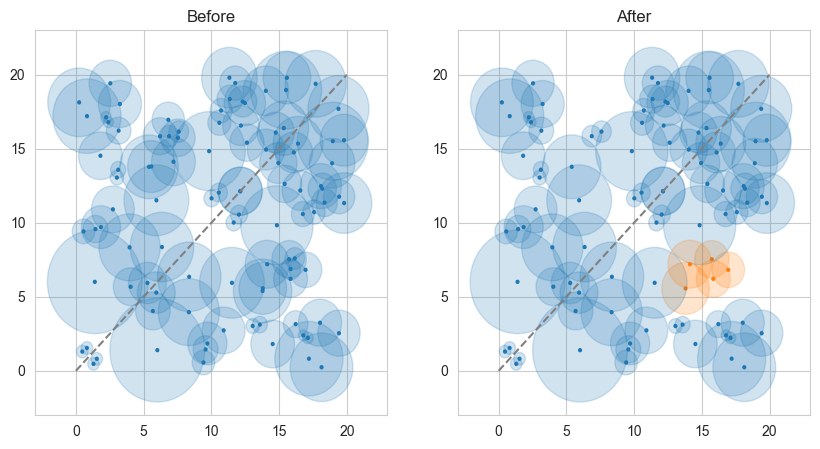

In [13]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(locations, ax=axs[0])
axs[0].set_title("Before")

aa.plot.locations(candidates, highlight=graph.keys(), ax=axs[1])
axs[1].set_title("After")

As a last example, let's compare this to the second graph starting with location 94.

In [66]:
graph, candidates = aa.neighbor_graph(locations, location_id=94)

Text(0.5, 1.0, 'After')

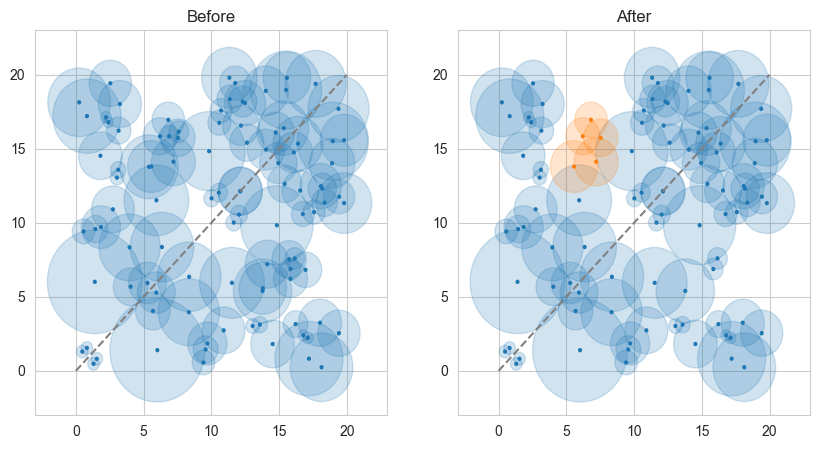

In [67]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(locations, ax=axs[0])
axs[0].set_title("Before")

aa.plot.locations(candidates, highlight=graph.keys(), ax=axs[1])
axs[1].set_title("After")

In [68]:
graph, candidates = aa.neighbor_graph(locations, location_id=45)

Text(0.5, 1.0, 'After')

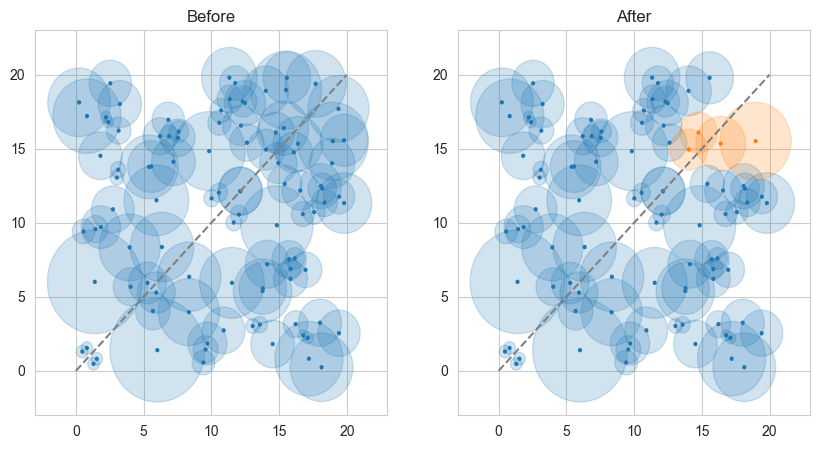

In [69]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(locations, ax=axs[0])
axs[0].set_title("Before")

aa.plot.locations(candidates, highlight=graph.keys(), ax=axs[1])
axs[1].set_title("After")

In [70]:
graph, candidates = aa.neighbor_graph(locations, location_id=95)

Text(0.5, 1.0, 'After')

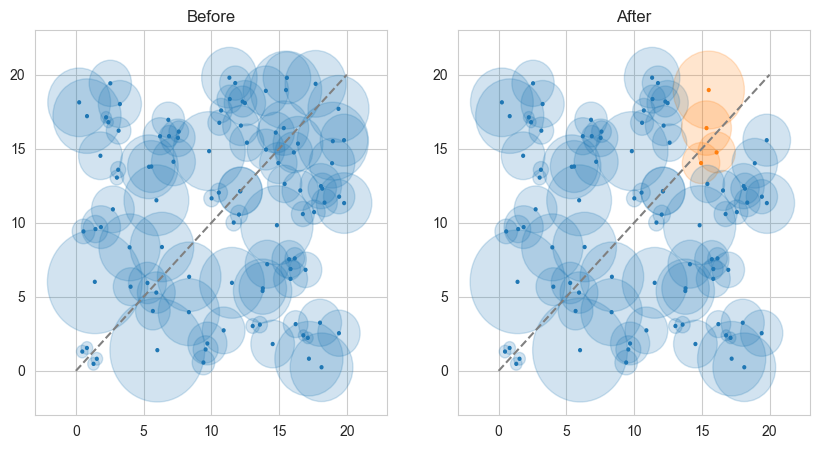

In [71]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(locations, ax=axs[0])
axs[0].set_title("Before")

aa.plot.locations(candidates, highlight=graph.keys(), ax=axs[1])
axs[1].set_title("After")

# Generating Solutions

Now that we have an intuition for how the approach works, let's run the process in a loop to generate a complete "solution".

In [16]:
def solve(probes: DataFrame) -> DataFrame:
    """Generate solution probes set from locations."""

    # Catalog locations
    locations = aa.catalog_locations(probes)
    
    # Initialize candidates to all locations
    candidates = locations
    selected_locations = set()
        
    # Iterate as long as there are at least 2 probes left
    while candidates.probe_id.nunique() > 1:
    
        # Create neighbor graphs for every candidate location
        graphs = {}
        for location_id in candidates.index:
            graphs[location_id] = aa.neighbor_graph(candidates, location_id=location_id)[0]
    
        # Record lengths
        df = DataFrame(
            [
                {
                    "location_id": location_id, 
                    "length": len(graphs[location_id]),
                }
                for location_id in graphs
            ]
        )

        # Keep only the largest graphs
        df = df[df.length == df.length.max()]
        
        # Randomly pick one to generate slightly different solutions each time
        location_id = df.location_id.sample().item()
        
        # Regenerate and record graph
        graph, remaining = aa.neighbor_graph(candidates, location_id=location_id)
    
        # Record selected locations
        selected_locations |= graph.keys()

        # Remove selected locations from candidates and repeat
        candidates = remaining[~remaining.index.isin(selected_locations)]

    # Construct initial solution
    df = locations[locations.index.isin(selected_locations)]
    df = df.set_index("probe_id")

    # It's possible we discarded both locations for a single probe. If that's true, add the original locations back in.
    missing_probes = probes.index.difference(df.index)
    if len(missing_probes) > 0:
        df = pd.concat([df, probes[probes.index.isin(missing_probes)]])

    # Sort solution so its pretty
    df = df.sort_index()

    # Verify output
    aa.verify_probes(df)    
    assert len(probes) == len(df)
    assert probes.index.isin(df.index).all()
    
    return df

In [17]:
# Generate solution
solution = solve(probes)
solution.head()

,x,y,distance_expected,distance_expected_err
probe_id,,,,
0,1.302734,0.472751,0.428625,0.021431
1,5.944659,11.519452,2.392850,0.119642
2,15.411657,12.623399,1.264116,0.063206
3,8.340580,3.964348,2.261914,0.113096
4,9.833046,14.837630,2.668234,0.133412


Let's compare this solution to the original baseline data.

Text(0.5, 1.0, 'Solution (score=120.9)')

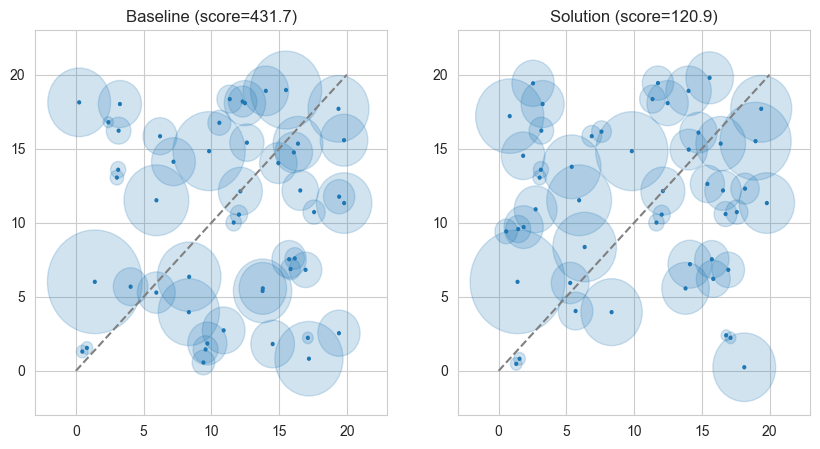

In [18]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(probes, ax=axs[0])
score = aa.score_probes(probes)
axs[0].set_title(f"Baseline (score={score:0.1f})")

aa.plot.locations(solution, ax=axs[1])
score = aa.score_probes(solution)
axs[1].set_title(f"Solution (score={score:0.1f})")

While this is a randomly chosen solution, hopefully it's significantly better than the baseline. If you look closely at the locations and expected distance regions, you should see a lot less overlap.

# Optimization

In the last section we "solved" the original problem by randomly picking from the largest graphs. How big a difference does this make?

In [47]:
percent_unique = []
solutions = []
for _ in tqdm(range(300)):
    solutions.append(solve(probes))
    
    checksums = [aa.checksum_solution(solution) for solution in solutions]
    percent_unique.append(len(np.unique(checksums)) / len(solutions))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [07:22<00:00,  1.48s/it]


## Scores

We generated 300 solutions above. Let's compare their scores to get a sense for how much variation the random graph selection generates.

In [51]:
scores = {i: aa.score_probes(solution) for i, solution in enumerate(solutions)}

<Axes: ylabel='Count'>

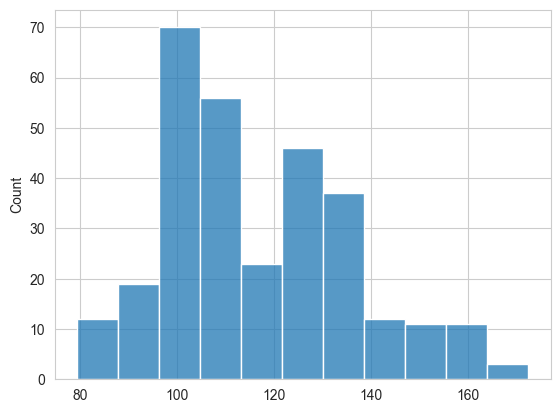

In [52]:
sns.histplot(x=scores.values())

We can see the scores range from roughly 80 to 170. But since the score is an abstract measure, it's hard to know if this variation is significant. That said, all of the solutions are roughly 4x better than the baseline score of 432.

Let's compare solutions at either end of the range to get a sense for how a low scoring solution differs from a high scoring solution.

In [53]:
solution_id = np.random.choice([k for k, v in scores.items() if v < 85])
print(f"Selected solution {solution_id}")

solution0 = solutions[solution_id]

Selected solution 173


In [54]:
solution_id = np.random.choice([k for k, v in scores.items() if v > 160])
print(f"Selected solution {solution_id}")

solution1 = solutions[solution_id]

Selected solution 46


Text(0.5, 1.0, 'High End (score=162.1)')

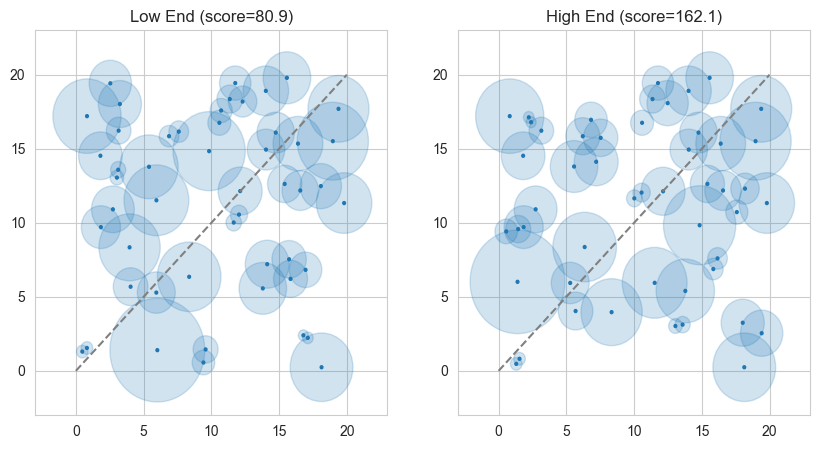

In [55]:
_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(solution0, ax=axs[0])
score = aa.score_probes(solution0)
axs[0].set_title(f"Low End (score={score:0.1f})")

aa.plot.locations(solution1, ax=axs[1])
score = aa.score_probes(solution1)
axs[1].set_title(f"High End (score={score:0.1f})")

How different are these solutions? Let's try highlighting locations they have in common.

Text(0.5, 1.0, 'High End (score=162.1)')

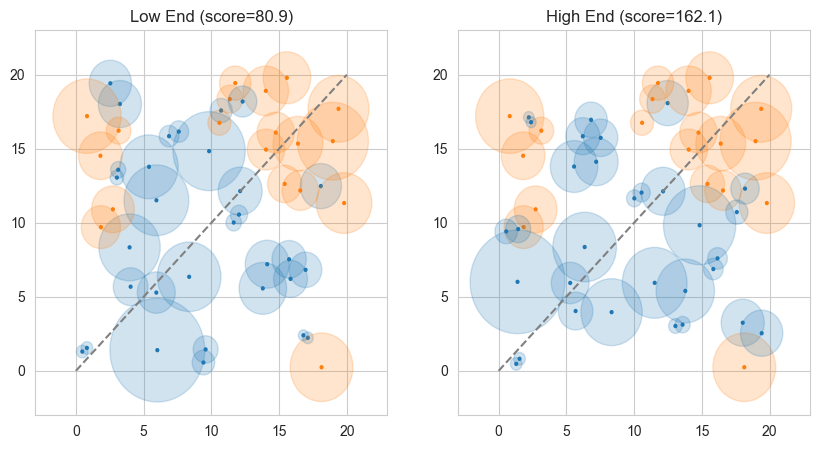

In [56]:
df = solution0.join(solution1, lsuffix="1", rsuffix="2")
df = df[df.x1 == df.x2]

_, axs = plt.subplots(ncols=2, figsize=(10, 5))

aa.plot.locations(solution0, highlight=df.index, ax=axs[0])
score = aa.score_probes(solution0)
axs[0].set_title(f"Low End (score={score:0.1f})")

aa.plot.locations(solution1, highlight=df.index, ax=axs[1])
score = aa.score_probes(solution1)
axs[1].set_title(f"High End (score={score:0.1f})")

## Unique Solutions

So far we've been assuming that each solution is unique. Randomly selecting the largest graphs definitely generates a variety of solutions but is there a limit to the number of unique solutions?

The plot below shows a steady decline in the percentage of unique solutions. By fitting a linear regression line to the last 200 data points where we see steady decline, we can extrapolate to estimate total number of unique solutions.

<Axes: >

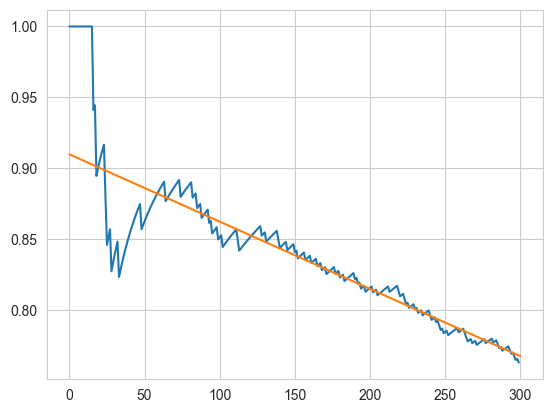

In [75]:
# Fit regression line to last 200 data points where we see steady decline
m, b = np.polyfit(np.arange(100, len(percent_unique)), percent_unique[100:], deg=1)

# Plot percent unique
sns.lineplot(x=np.arange(0, len(percent_unique)), y=percent_unique)

# Plot regression line
sns.lineplot(x=[0, len(percent_unique)], y=[b, m*len(percent_unique)+b])

In [76]:
# Solve m*x + b = 0 to estimate total unique solutions
estimate = -b / m
estimate

1920.6516304521576

# Summary

We saw that clustering locations by best fit and then iterating through them from largest to smallest clearly generates much better solutions than the baseline data. However, it's not yet clear how to choose from a large number of subtly different solutions.